# EfficientNetB0 avec TensorFlow/Keras
-> Fait partie de la famille des réseaux de neurones convolutif (CNN)

### Charger et préparer les données du dataset
- Normalisation
    - ImageDataGenerator permet de préparer les images pour l'entraînement   
    - rescale=1./255 permet de normaliser les valeurs des pixels entre 0 et 1   
- Aplatissement des images   
    - reshaping (transforme les tableaux 3D en tableaux 2D) avec target_size    
- Encodage des labels   
    -  class_mode='categorical', convertis les labels en vecteurs one-hot encodés -> adapté pour la classification multiclasses

In [1]:
import os
import sys
import warnings
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

sys.path.insert(0, '..')
from Utils import create_data_generator

# path des datasets
train_dir = '../dataset/train'
val_dir = '../dataset/val'
test_dir = '../dataset/test'

seed = 42 # pour la reproductibilité

target_size = (224, 224)  # 224 x 224 px
train_batch_size = 32 # traitement par lot de 32 images
val_batch_size = 1
test_batch_size = 32
color = 'rgb'

# chargement de train
train_generator = create_data_generator( data_dir=train_dir, batch_size=train_batch_size, color_mode=color, seed=seed, shuffle=True,)
val_generator = create_data_generator( data_dir=val_dir, batch_size=val_batch_size, color_mode=color, seed=seed, shuffle=True,)
test_generator = create_data_generator( data_dir=test_dir, batch_size=test_batch_size, color_mode=color, seed=seed, shuffle=False,)

print("index des classes détectées :", train_generator.class_indices)

Found 5141 images belonging to 3 classes.
Found 99 images belonging to 3 classes.
Found 616 images belonging to 3 classes.
index des classes détectées : {'bacteria': 0, 'normal': 1, 'virus': 2}


## Definition du modèle

1) On charge le modèle EfficientNetB0, sans la tête de classification (include_top=False). Les poids sont pré-entraîné sur ImageNet.


In [2]:
# # charger le modèle
# base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
# # couche de sortie du modèle de base
# x = base_model.output 
# x = GlobalAveragePooling2D()(x)
# # couche dense de classification finale avec une activation softmax
# output_tensor = Dense(len(train_generator.class_indices), activation='softmax')(x)
# # créer le modèle complet
# model = Model(inputs=base_model.input, outputs=output_tensor)
# # compiler le modèle
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # résumé du modèle
# # model.summary()

# # nb de couches
# print(f"nb total de couches dans le modèle : {len(model.layers)}")
# # output : nb total de couches dans le modèle : 240

Note : Je souhaite tester le modèle avec un nombre de couches limité à 16 + 4 couches, pour alléger l'entrainement :   

2) Avec GlobalAveragePooling2D à x, on reduit de la sortie 4D (batch_size, height, width, channels) à une sortie 2D (batch_size, channels)   
3) L'avant dernière couche possède 128 neurones   
   -> activation='relu' : valeurs négatives = 0, valeurs positives = inchangées   
Souvent utilisé dans les couches cachées   
   La couche dense finale a 3 neurones => 3 classes (bacteria, normal, virus)   
    -> activation='softmax': transforme les valeurs en probabilités entre 0 et 1 (Utilisée la classification multi-classes)   
4) Compilation du Modèle : Pour l'entraînement on spécifie l'optimiseur, la fonction de perte et les métriques à suivre   
- optimizer Adam -> algo de descente de gradient stochastique (ajuste les taux d'apprentissage pour chaque paramètre)   
learning_rate = taille des pas que le modèle fait lors de chaque mise à jour des paramètres (poids et biais) pour minimiser la fonction de perte   
-> (θ nouveau = θ ancien − learning_rate x gradient)   
- loss='categorical_crossentropy'   
- metrics=['accuracy'] : métric pour suivre la précision (accuracy) -> nb de prédictions correctes par le nb total d'échantillons   
ex : si Accuracy= 90/100= cela signifie que l'accuracy est de 0,90 -> 90 %   

In [3]:
from Utils import print_layer_info
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)

# charger le modèle EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
# tronque après la 16e couche
base_model_truncated = Model(inputs=base_model.input, outputs=base_model.layers[22].output)  
x = base_model_truncated.output # couche de sortie
x = GlobalAveragePooling2D()(x) # réduction de la sortie 4D à une sortie 2D
# x = Dropout(0.5)(x)  # ajout d'une couche avec 50% des neuronnes desactivés aléatoirement à chaque mise à jour des poids
x = Dense(128, activation='relu')(x)

output_tensor = Dense(len(train_generator.class_indices), activation='softmax')(x)
# créer le modèle complet
model = Model(inputs=base_model.input, outputs=output_tensor)
# compiler le modèle
model.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# print les infos des couches
print_layer_info(model)

nb total de couches dans le modèle : 26
Détail :
Layer 1 (InputLayer)
Layer 2 (Rescaling)
Layer 3 (Normalization)
Layer 4 (Rescaling)
Layer 5 (ZeroPadding2D)
Layer 6 (Conv2D) : 32 filtres
Layer 7 (BatchNormalization)
Layer 8 (Activation)
Layer 9 (DepthwiseConv2D)
Layer 10 (BatchNormalization)
Layer 11 (Activation)
Layer 12 (GlobalAveragePooling2D)
Layer 13 (Reshape)
Layer 14 (Conv2D) : 8 filtres
Layer 15 (Conv2D) : 32 filtres
Layer 16 (Multiply)
Layer 17 (Conv2D) : 16 filtres
Layer 18 (BatchNormalization)
Layer 19 (Conv2D) : 96 filtres
Layer 20 (BatchNormalization)
Layer 21 (Activation)
Layer 22 (ZeroPadding2D)
Layer 23 (DepthwiseConv2D)
Layer 24 (GlobalAveragePooling2D)
Layer 25 (Dense) : 128 neurones
Layer 26 (Dense) : 3 neurones


## Entraîner le modèle
Processus
- Training : le modèle est entraîné sur les données de train
- Validation : après chaque epoch, le modèle est évalué sur les données fournies par val_generator pour mesurer ses performances

Les paramètres de la méthode fit de Keras pour l'entraînement
- train_generator : fournit les batches de train
- epochs=3 -> nb de passages (epochs) sur l'ensemble des données d'entraînement
- validation_data : fournit les batches de données de validation

history (instance de la classe History) est l'objet retournée par model.fit
-> contient des informations sur la progression de l'entraînement (valeurs des pertes et métriques pour chaque epoch pour l'entraînement et la validation).

In [4]:
# Entraîner le modèle
print("Démarrage de l'entraînement...")
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
)

Démarrage de l'entraînement...
Epoch 1/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.2607 - loss: 2.1445 - val_accuracy: 0.3333 - val_loss: 1.4687
Epoch 2/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.2745 - loss: 1.2424 - val_accuracy: 0.3434 - val_loss: 1.0988
Epoch 3/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.4936 - loss: 1.0284 - val_accuracy: 0.3333 - val_loss: 1.2746


## Évaluation et sauvegarde du modèle

test_loss : La perte (erreur) du modèle sur les données de test
test_acc : La précision du modèle sur le jeu de données de test

In [5]:
# Évaluer à présent la perf du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy : {test_acc}')
print(f'Test loss : {test_loss}')

# sauvegarder le modèle complet (architecture + poids)
model.save('../models/efficientnet_model.keras')
print("Modèle sauvegardé avec succès dans ../models/efficientnet_model.keras")

20/20 - 13s - 672ms/step - accuracy: 0.3799 - loss: 1.1575

Test accuracy : 0.37987011671066284
Test loss : 1.1575051546096802
Modèle sauvegardé avec succès dans ../models/efficientnet_model.keras


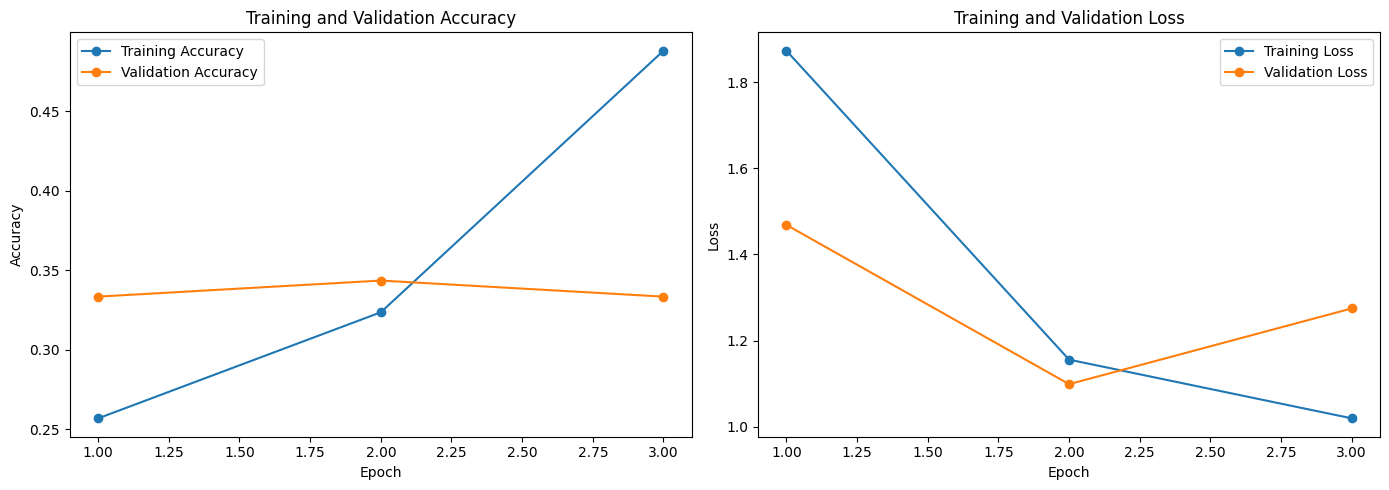

In [6]:
# tracer l'accuracy et la perte
from Utils import plot_accuracy_and_loss

plot_accuracy_and_loss(history)

- TP = nb de vrais positifs
- FP = nb de faux positifs
- FN = nb de faux négatifs

### Matrice de confusion :

- Classe 0 : [TN classe 0, FP classe 1, FP classe 2] 
- Classe 1 : [FP classe 0, TN classe 1, FP classe 2]
- Classe 2 : [FN classe 0, FN classe 1, TP classe 2]


### Rapport de classification dans le jeu de test

Precision : proportion de prédictions positives qui sont réellement correctes
`Precision = TP ÷ (TP+FP)`

Recall (Sensibilité) : proportion de cas positifs réels correctement identifiés par le modèle (mesure l'aptitude du modèle à détecter tous les cas positifs) 
`Recall = TP ÷ (TP+FN)`

F1-Score : Combine la précision et le recall en une seule métrique (précision + sensibilité)
`f1_score = 2 * (precision * recall) ÷ (precision + recall)`

Support : Le nb d'exemple dans le jeu de test pour chaque classe 
-> class 0 (bacteria) = 242 images
-> class 1 (normal) = 234 images
-> classe 2 (virus) = 140 images

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from Utils.metrics_util import Metrics_utils
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Performance du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

# Prédictions
y_pred = model.predict(test_generator)
# Trouve l'indice de la valeur max sur l'axe 1 -> quelle classe a la probabilité la plus élevée ?
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('\nConfusion Matrix:')
print(conf_matrix)

# Rapport de classification
class_report = classification_report(y_true, y_pred_classes, zero_division=0)
print('\nClassification Report:')
print(class_report)

print("---\nSince the tests were inconclusive, let's move on to another CNN approach/architecture !")


20/20 - 11s - 544ms/step - accuracy: 0.3799 - loss: 1.1575

Test accuracy: 0.37987011671066284
Test loss: 1.1575051546096802
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 561ms/step

Confusion Matrix:
[[  0 242   0]
 [  0 234   0]
 [  0 140   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       242
           1       0.38      1.00      0.55       234
           2       0.00      0.00      0.00       140

    accuracy                           0.38       616
   macro avg       0.13      0.33      0.18       616
weighted avg       0.14      0.38      0.21       616

---
Since the tests were inconclusive, let's move on to another CNN approach/architecture !
